<a href="https://colab.research.google.com/github/AanchalA/WeekendProjects/blob/main/M6_L10_Project_2_Building_a_collaborative_Multi_Agent_System_in_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a collaborative Multi-Agent System in LangGraph


[Example 2: Multi agent application with LangGraph](https://github.com/langfuse/langfuse-docs/blob/main/cookbook/integration_langgraph.ipynb)

This project will cover a full hands-on workflow and demonstration of how to build a collaborative Multi-Agent System in LangGraph to build your own Data Analyst!

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4o`, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert".
This is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation, by Wu, et. al.](https://arxiv.org/pdf/2308.08155)

The typical workflow here would be to have the following:

- A Researcher Agent which can leverage tools like search to get live information from user queries
- A Chart Generator Agent which is an expert in taking data and building visualizations in Python
- A router which will help in calling the right agent and tools based on the current state in the agent.

We will build this in LangGraph using the following workflow:

![](https://i.imgur.com/t4RGrJo.png)


# 1. Installing Dependencies

Install the following httpx library version for compatibility with other libraries

In [17]:
! pip install -q httpx
! pip install -q wikipedia
! pip install -q langfuse
! pip install -q langchain
! pip install -q langgraph
! pip install -q tavily-python
! pip install -q langchain-openai
# ! pip install -q langchain-community
! pip install -q langchain-huggingface
! pip install -q langchain-experimental

  Preparing metadata (setup.py) ... done


# 2. API Key Setup

In [4]:
import os
from google.colab import userdata

os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')
os.environ['LANGFUSE_SECRET_KEY'] = userdata.get('LANGFUSE_SECRET_KEY')
os.environ['LANGFUSE_PUBLIC_KEY'] = userdata.get('LANGFUSE_PUBLIC_KEY')

In [5]:
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"

In [ ]:
# # LangSmith Setup
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = f"My LLM App Project"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = LANGSMITH_KEY

# 3. Building a Collaborative Multi-Agent Agentic AI System


## 3.1. State Graph / State Machine

This is just a list of messages, along with a key to track the most recent sender

In [114]:
import operator
import networkx as nx
from langchain_core.messages import BaseMessage
from typing import Annotated, Sequence, TypedDict, List, Any

In [46]:
# This defines the object that is passed between each node in the graph.
# We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    agent_scratchpad: List[Any] # Or str, depending on
    knowledge_graph: Optional[nx.Graph]
    sender: str

## 3.2. Creating Tools and Tool Nodes


In [10]:
from typing import Annotated
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

### 3.2.1. Web Search Tool

In [11]:
tv_search = TavilySearchResults(max_results=5,
                                search_depth='advanced',
                                max_tokens=10000)

In [12]:
search_tool = [tv_search]
search_tool_name = tv_search.name

### 3.2.2. Python Tool

In [13]:
repl = PythonREPL()

@tool
def python_repl(code: Annotated[str, "The python code to execute to generate your chart."],):
    """Use this to execute python code.
       If you want to see the output of a value,
       you should print it out with `print(...)`.

       This is visible to the user."""

    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER.")

In [14]:
chart_tool = [python_repl]
chart_tool_name = python_repl.name

### 3.2.3. Defining Tool Node in the State Graph

Defines the tools we would be using in the multi-agent system

In [15]:
tools = [tv_search, python_repl]
tool_node = ToolNode(tools)

### 3.2.4. Other Tools - Wikipedia Tool, Current DateTime Tool

In [18]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

# Define a tools that searches Wikipedia
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [19]:
from datetime import datetime
from langchain.tools import Tool

# Define a new tool that returns the current datetime
datetime_tool = Tool(
    name="Datetime",
    func = lambda x: datetime.now().isoformat(),
    description="Returns the current datetime",
)

## 3.3. Creating LLM Based Agents
We create two main agents here:

1. The Researcher Agent which can access the web search tool to make web searches to get information on user queries

2. The Chart Agent which can use python to create data visualizations

In [61]:
from langchain_openai import ChatOpenAI
# from langchain_community.chat_models import ChatHuggingFace
from langchain_core.messages import ToolMessage, AIMessage
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [83]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [63]:
# chat_model = HuggingFaceEndpoint(repo_id="google/gemma-3-4b-it",
#                                  task="text-generation",
#                                  max_new_tokens=512,
#                                  do_sample=False,
#                                  repetition_penalty=1.03,)

# llm = ChatHuggingFace(llm=chat_model)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


### 3.3.1. Supervisor Agent

In [64]:
supervisor_agent = """You are the Supervisor AI in a collaborative, multi-agent assistant system.
Your responsibility is to analyze user queries and orchestrate a team of expert agents
to efficiently solve the task by selecting the appropriate next step.

You have access to the following agents:
- Researcher: Can search the internet or structured databases to find accurate, up-to-date data.
- ChartBuilder: Can generate visualizations like bar charts and graphs from structured data.

Follow these guidelines:

- Given the conversation so far, decide which agent should act next, or if the task is complete.
- Think step-by-step. Consider what information is still needed and which agent is best equipped to handle it.
- Only call one agent per step.
- Return your decision in the following JSON format:
  {"next": "Researcher"} or {"next": "ChartBuilder"} or {"next": "FINISH"}

Additionally, include a brief rationale for your decision to help future debugging and traceability. Example:
  {"next": "Researcher", "reason": "The question requires current GDP data, which the Researcher can retrieve."}

You are managing an intelligent workflow — be deliberate and efficient."""


### 3.3.2. Researcher Agent

In [65]:
researcher_agent = """You are a specialized Researcher AI, collaborating with other expert agents to fulfill complex tasks.
Your job is to gather accurate and up-to-date information using the following tools:
{search_tool_name}

Follow these guidelines:

- Use the tools to gather factual, reliable data.
- Make partial progress toward answering the main question if you cannot fully answer it.
- Format data clearly so others can use it — structure outputs (e.g., JSON, bullet points) where appropriate.
- If you believe the full answer or deliverable has been found, prefix your output with: FINAL ANSWER
- If not final, clearly explain what was retrieved and what needs to be done next.
- Do not speculate. Use only the information you’ve gathered or already know.

You are part of a larger team — leave clear notes or data for the next agent if you are passing the task forward."""


In [66]:
research_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", f"""You are a helpful AI assistant, collaborating with other assistants.
                        Use the provided tools to progress towards answering the question.
                        If you are unable to fully answer, that's OK,
                        another assistant with different tools will help where you left off.
                        Execute what you can to make progress.
                        If you or any of the other assistants have the final answer or deliverable,
                        prefix your response with FINAL ANSWER so the team knows to stop.

                        You have access to the following tools:
                        {search_tool_name}

                        You should provide accurate data for use
                        and source code shouldn't be the final answer
                    """,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

In [84]:
research_agent = (research_prompt | llm.bind_tools(search_tool))

### 3.3.3. Chart Builder Agent

In [68]:
chart_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", f"""You are a helpful AI assistant, collaborating with other assistants.
                        Use the provided tools to progress towards answering the question.
                        If you are unable to fully answer, that's OK,
                        another assistant with different tools will help where you left off.
                        Execute what you can to make progress.
                        If you or any of the other assistants have the final answer or deliverable,
                        prefix your response with FINAL ANSWER so the team knows to stop.

                        You have access to the following tools:
                        {chart_tool_name}

                        Run the python code to display the chart
                    """,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

In [85]:
chart_agent = (chart_prompt | llm.bind_tools(chart_tool))

### 3.3.4. Knowledge Graph Builder Agent

In [ ]:
kg_extraction_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", f"""You are a network graph maker.
                    Extract entities and relationships from the user-provided text.
                    Format the output as a JSON list of lists.
                    Each inner list should represent a relationship:
                    'SUBJECT-PREDICATE-OBJECT' --> [ENTITY_1, RELATIONSHIP, ENTITY_2].
                    Use 'is_a' for classifications (e.g., [Bob, is_a, Person]).
                    Only output the JSON list, no preamble or explanation.
                    """,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

In [ ]:
kg_extraction_chain = (kg_extraction_prompt | llm)

In [ ]:
def extract_and_update_kg(text_to_process: str, current_graph: Optional[nx.Graph]) -> nx.Graph:
    """Extracts KG triples from text and updates a NetworkX graph."""

    if not text_to_process:
        print("No text provided for KG extraction.")
        return current_graph if current_graph else nx.Graph()

    # Initialize graph if it doesn't exist
    graph = current_graph if current_graph is not None else nx.Graph()

    print(f"\n--- Updating KG based on text: ---\n{text_to_process}\n---------------------------------")

    try:
        # Call LLM to extract triples
        extraction_response = kg_extraction_chain.invoke({"input_text": text_to_process})
        # Expecting content like: "[['entity1', 'relation', 'entity2'], ...]"
        # Basic parsing (robust error handling recommended for production)
        import json
        triples = json.loads(extraction_response.content)

        if not isinstance(triples, list):
             print(f"Warning: KG extraction did not return a list: {triples}")
             return graph

        print(f"--- Extracted Triples: --- \n{triples}\n-------------------------")

        # Add extracted triples to the graph
        for triple in triples:
            if isinstance(triple, list) and len(triple) == 3:
                subject, predicate, obj = triple
                # Add nodes (handles duplicates automatically)
                graph.add_node(subject, label=subject)
                graph.add_node(obj, label=obj)
                # Add edge with the relationship as an attribute
                graph.add_edge(subject, obj, label=predicate)
            else:
                print(f"Warning: Skipping malformed triple: {triple}")

    except json.JSONDecodeError:
        print(f"Warning: Could not decode JSON from KG extraction response: {extraction_response.content}")
    except Exception as e:
        print(f"An error occurred during KG extraction or update: {e}")

    return graph

## 3.4. Defining Agent Nodes in the State Graph

These functions would actually call the agents as necessary and update the state in the agent

### 3.4.1. Researcher Agent Node

In [100]:
def research_agent_node(state):
    result = research_agent.invoke(state)

    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.model_dump(exclude={"type", "name"}), name="Researcher")

    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": "Researcher",
    }

### 3.4.2. Chart Builder Agent Node

In [101]:
def chart_agent_node(state):
    result = chart_agent.invoke(state)

    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.model_dump(exclude={"type", "name"}), name="chart_generator")

    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": "chart_generator",
    }

### 3.4.3. Knowledge Graph Builder Agent Node

In [ ]:
def knowledge_graph_updater_node(state: AgentState) -> dict:
    """Node to update the knowledge graph based on the last message."""
    print("--- Running KG Updater Node ---")

    # Get the last message (assuming it's the output to process)
    last_message = state['messages'][-1] if state['messages'] else None
    text_content = ""

    if last_message and isinstance(last_message, BaseMessage):
         # Handle potential complex content if necessary
         if isinstance(last_message.content, str):
              text_content = last_message.content
         # Add handling if content is list of blocks etc.
         # elif isinstance(last_message.content, list):
         #    text_content = " ".join(str(item) for item in last_message.content)

    current_graph = state.get('knowledge_graph') # Use .get for safety

    # Perform extraction and update
    updated_graph = extract_and_update_kg(text_content, current_graph)

    # Return the updated graph. Crucially, do NOT modify 'next_step_indicator' here.
    # It should have been set by the *previous* node (Researcher/Chart Gen).
    return {"knowledge_graph": updated_graph}

## 3.5. Defining Edge Logic

Defines some of the conditional edge logic that is needed to decide what to do based on results of the agents




In [102]:
from typing import Literal

In [103]:
# Either agent can decide to end

def router(state) -> Literal["call_tool", "__end__", "continue"]:

    # This is the router
    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"

    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"

    return "continue"

## 3.6. Defining the Multi-Agent Graph

We can now put it all together and define the graph!



In [104]:
from langgraph.graph import END, StateGraph
from langfuse.callback import CallbackHandler
from IPython.display import Image, display, Markdown

In [105]:
agent = StateGraph(AgentState)

In [106]:
agent.add_node("Researcher", research_agent_node)
agent.add_node("chart_generator", chart_agent_node)
agent.add_node("call_tool", tool_node)
builder.add_node("knowledge_graph_updater", knowledge_graph_updater_node)

In [ ]:
builder.add_edge("Researcher", "knowledge_graph_updater")

In [107]:
agent.add_conditional_edges(
    "Researcher",
    router,
    # routing map:
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)

In [108]:
agent.add_conditional_edges(
    "chart_generator",
    router,
    # routing map:
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

In [109]:
agent.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],          ## Which agent sent this tool call request???
    # routing map:
    {"Researcher": "Researcher", "chart_generator": "chart_generator"},
)

In [110]:
agent.set_entry_point("Researcher")
# agent = agent.compile()

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

# State Graph Compile
agent = agent.compile().with_config({"callbacks": [langfuse_handler]})

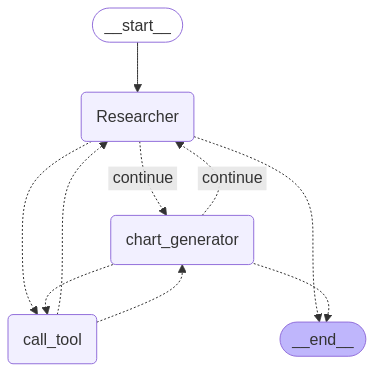

In [111]:
display(Image(agent.get_graph().draw_mermaid_png()))

## 3.7. Test the Multi-Agent System and Logging with LangFuse

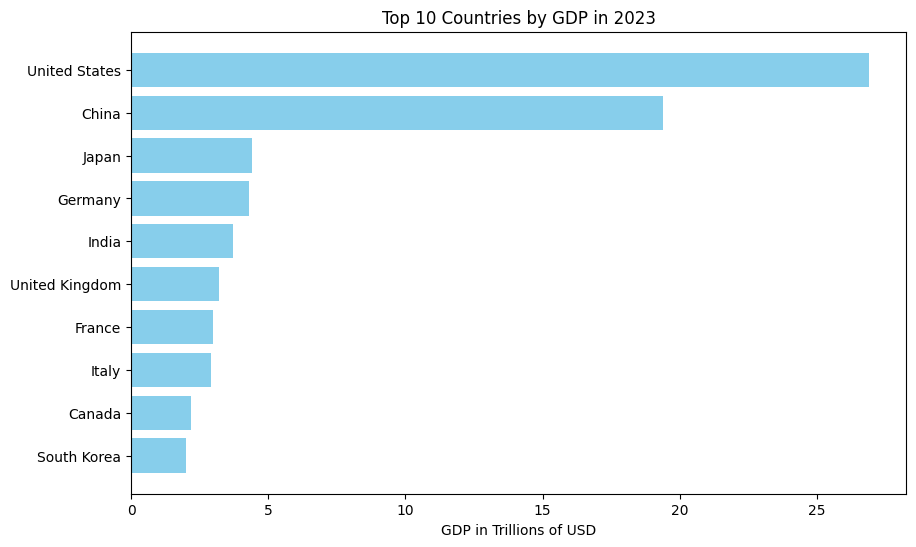

In [112]:
prompt = """Fetch the data of the top 10 countries with the highest GDP in the world.
            Then use this data and draw a bar chart.
         """

# Combine messages and scratchpad into the input dictionary
initial_input_state = {
    "messages": [('human', prompt)],
    "agent_scratchpad": []      # Add scratchpad here
}

# Configuration dictionary (only runtime options)
config = {"recursion_limit": 150}

# Call invoke with the combined input state and the config
response = agent.invoke(initial_input_state, config)

In [113]:

# Check the scratchpad in the final state
final_scratchpad = response.get('agent_scratchpad')
print("\n--- Final Agent Scratchpad ---")
print(final_scratchpad)
print("-----------------------------")


--- Final Agent Scratchpad ---
[]
-----------------------------


In [99]:
response

{'messages': [('human',
   'Fetch the data of the top 10 countries with the highest GDP in the world.\n            Then use this data and draw a bar chart.\n         '),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6PDj7nAgLoS8G3eKEaSfDQP8', 'function': {'arguments': '{"query":"top 10 countries with highest GDP 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 235, 'total_tokens': 263, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f7d56a8a2c', 'id': 'chatcmpl-BOIQ3YslhfewkEFbQ0XYeXEJDXF7s', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-b20c46e6-f0ed-4ec2-ad6a-0587248bcd06-0', tool_calls=[{'name'

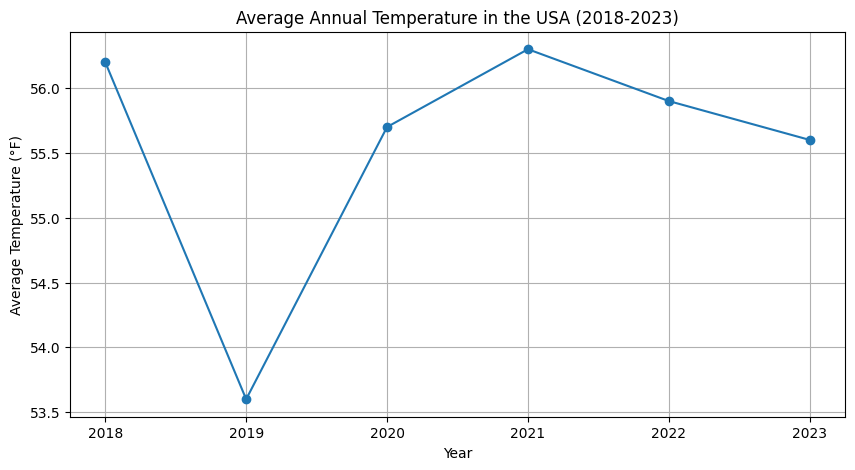

In [116]:
prompt = """Fetch the data of the average temperature of USA over the last decade.
            Then use this data and draw a line chart.
         """

# Combine messages and scratchpad into the input dictionary
initial_input_state = {
    "messages": [('human', prompt)],
    "agent_scratchpad": []      # Add scratchpad here
}

# Configuration dictionary (only runtime options)
config = {"recursion_limit": 150}

# Call invoke with the combined input state and the config
response = agent.invoke(initial_input_state, config)

In [117]:
response

{'messages': [('human',
   'Fetch the data of the average temperature of USA over the last decade.\n            Then use this data and draw a line chart.\n         '),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZfkaT0ZPPHQ6gp5TJ7hQoeDI', 'function': {'arguments': '{"query":"average temperature USA last decade"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 232, 'total_tokens': 255, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f7d56a8a2c', 'id': 'chatcmpl-BOJ8Ftt2PvtGuG1MHozO0W0VcrDkP', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-db321538-1c19-4e36-8d60-cc15b47b6462-0', tool_calls=[{'name': 'ta